EX 8 GPT LLM

In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset
import json
from transformers import AutoTokenizer, PreTrainedTokenizerFast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from tokenizers import Tokenizer
from tokenizers.processors import TemplateProcessing

In [2]:
torch.set_float32_matmul_precision("high")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
pip install -U datasets torchinfo huggingface_hub fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [5]:
from datasets import load_dataset
ds = load_dataset("stanfordnlp/imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [7]:
train = pd.DataFrame(ds['train'])
test = pd.DataFrame(ds['test'])

In [8]:
unsupervised = pd.DataFrame(ds['unsupervised'])

In [9]:
X_train, X_test =  train['text'], test['text']

In [10]:
X_train, X_val =  train_test_split(
    X_train, test_size=0.1, random_state=42)

In [11]:
print(len(X_train), len(X_val), len(X_test))

22500 2500 25000


In [12]:
checkpoint = 'HuggingFaceTB/SmolLM-135M-Instruct'
pretrained_tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [13]:
pretrained_tokenizer("Attention Is All You Need")

{'input_ids': [41319, 1431, 2018, 1206, 11448], 'attention_mask': [1, 1, 1, 1, 1]}

In [14]:
pretrained_tokenizer.tokenize("Attention Is All You Needasdasd")

['Attention', 'ĠIs', 'ĠAll', 'ĠYou', 'ĠNeed', 'as', 'das', 'd']

In [15]:
pretrained_tokenizer.special_tokens_map

{'bos_token': '<|im_start|>',
 'eos_token': '<|im_end|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|im_end|>',
 'additional_special_tokens': ['<|im_start|>', '<|im_end|>']}

In [16]:
tokenizer = Tokenizer.from_pretrained(checkpoint)

In [17]:
tokenizer.post_processor = TemplateProcessing(
        single="<|im_start|> $A <|im_end|>",
        special_tokens=[
            ("<|im_end|>", pretrained_tokenizer.eos_token_id),
            ("<|im_start|>", pretrained_tokenizer.bos_token_id),
        ],
    )
tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer,
        unk_token="<|endoftext|>",
        bos_token="<|im_start|>",
        pad_token="<|im_end|>",
        eos_token="<|im_end|>",
    )

In [18]:
tokenizer("Attention Is All You Need")

{'input_ids': [1, 41319, 1431, 2018, 1206, 11448, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [19]:
tokenizer("Attention Is All You Need", "Attention Is All You Need")

{'input_ids': [41319, 1431, 2018, 1206, 11448, 41319, 1431, 2018, 1206, 11448], 'token_type_ids': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
tokenizer.tokenize("Attention Is All You Need")

['Attention', 'ĠIs', 'ĠAll', 'ĠYou', 'ĠNeed']

In [21]:
tokenizer.vocab_size

49152

In [22]:
list(tokenizer.vocab)[:10]

['Ġhandheld',
 'ĠMO',
 'Ġcolleagues',
 'plication',
 'ę',
 'Ġmisfortune',
 'Fried',
 'vote',
 'iates',
 'ĠDeutsch']

In [23]:
X_train   = tokenizer(X_train.to_list())
X_val     = tokenizer(X_val.to_list())
X_test    = tokenizer(X_test.to_list())

In [24]:
tokenizer("Attention Is All You Need")

{'input_ids': [1, 41319, 1431, 2018, 1206, 11448, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [25]:
tokenizer.decode([1, 41319, 1431, 2018, 1206, 11448, 2])

'<|im_start|>Attention Is All You Need<|im_end|>'

In [26]:
tokenizer.tokenize("Attention Is All You Need")

['Attention', 'ĠIs', 'ĠAll', 'ĠYou', 'ĠNeed']

In [27]:
tokenizer("Attention Is All You Need").word_ids()

[None, 0, 1, 2, 3, 4, None]

In [28]:
tokenizer("Gradients")

{'input_ids': [1, 39844, 1526, 2], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [29]:
tokenizer.tokenize("Gradients")

['Grad', 'ients']

In [30]:
tokenizer.pad_token_id

2

In [31]:
def data_generator(X, max_len=512, batch_size=32, shuffle_data=True, pad_token_id=tokenizer.pad_token_id):

    input_ids = X['input_ids']

    if shuffle_data:
        input_ids = shuffle(input_ids)

    n_batches = int(np.ceil(len(input_ids) / batch_size))

    for batch in range(n_batches):
        end = min((batch + 1) * batch_size, len(input_ids))

        input_ids_batch = input_ids[batch * batch_size:end]

        batch_max_len = np.max([len(x) for x in input_ids_batch])
        batch_max_len = min(batch_max_len, max_len)

        for sample in range(len(input_ids_batch)):
            x = input_ids_batch[sample]
            if len(x) > batch_max_len:
                x = x[-batch_max_len:]
            pad = [pad_token_id] * (batch_max_len - len(x))
            input_ids_batch[sample] = x + pad

        input_ids_batch = torch.from_numpy(np.array(input_ids_batch)).long()

        yield input_ids_batch

In [32]:
torch.roll(torch.tensor([1, 2, 3, 4]), shifts=-1, dims=0)

tensor([2, 3, 4, 1])

In [33]:
[1, 2, 3]
[2, 3, 4]

[2, 3, 4]

In [34]:
def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               device):

    model.train()

    train_loss = []

    for input_ids in data_loader():
        input_ids = input_ids.to(device)
        optimizer.zero_grad()

        # shift targets backwards
        targets = input_ids.clone().detach()
        targets = torch.roll(targets, shifts=-1, dims=1)
        targets[:, -1] = tokenizer.pad_token_id
        # targets.shape: [n_samples, max_seq_len]

        y_pred = model(input_ids)
        # y_pred.shape: [n_samples, max_seq_len, vocab_size]
        # but PyTorch expects [n_samples, vocab_size, max_seq_len]
        # loss = loss_fn(y_pred.transpose(2, 1), targets)
        # the fast way to do it
        # y_pred.shape: [n_samples * max_seq_len, vocab_size]
        loss = loss_fn(
                y_pred.reshape((-1, y_pred.size(-1))),
                targets.reshape(-1),
            )
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

    return np.mean(train_loss)

def test_step(model,
              data_loader,
              loss_fn,
              device):
    model.eval()

    test_loss = []

    with torch.inference_mode():
        for input_ids in data_loader():
            input_ids = input_ids.to(device)

            targets = input_ids.clone().detach()
            targets = torch.roll(targets, shifts=-1, dims=1)
            targets[:, -1] = tokenizer.pad_token_id
            # targets.shape: [n_samples, max_seq_len]
            y_pred = model(input_ids)
            # y_pred.shape: [n_samples, max_seq_len, vocab_size]
            # but PyTorch expects [n_samples, vocab_size, max_seq_len]
            # loss = loss_fn(y_pred.transpose(2, 1), targets)
            # the fast way to do it
            loss = loss_fn(
                    y_pred.reshape((-1, y_pred.size(-1))),
                    targets.reshape(-1),
                )

            test_loss.append(loss.item())

    return np.mean(test_loss)

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "test_loss": [],
        }

    model.to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss = train_step(model=model,
                                data_loader=train_data_loader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        end_time = timer()
        test_loss = test_step(model=model,
          data_loader=test_data_loader,
          loss_fn=loss_fn,
          device=device)

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"time: {(end_time-start_time):.4f}"
        )

    return results

In [35]:
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()


In [36]:
torch.tril(torch.ones(5, 5))

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

In [37]:
cm = torch.tril(torch.ones(5, 5)).view(1, 1, 5, 5)
cm

tensor([[[[1., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0.],
          [1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.]]]])

In [38]:
cm.masked_fill(cm[:, :, :5, :5] == 0, float('-inf'))

tensor([[[[1., -inf, -inf, -inf, -inf],
          [1., 1., -inf, -inf, -inf],
          [1., 1., 1., -inf, -inf],
          [1., 1., 1., 1., -inf],
          [1., 1., 1., 1., 1.]]]])

In [39]:
torch.ones([1, 4])

tensor([[1., 1., 1., 1.]])

In [40]:
torch.ones([1, 4]).view(1, 1, 1, 4)

tensor([[[[1., 1., 1., 1.]]]])

In [41]:
tensor = torch.ones([1, 4])
tensor[:, None, None, :]

tensor([[[[1., 1., 1., 1.]]]])

In [42]:
# Causal Self Attention from scrach
class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, max_len):
        # D: d_model i.e. model size
        # d_v: value head size
        # d_k: key head size
        # h: n_heads
        # Assume d_v = d_k
        super().__init__()
        assert d_model % n_heads == 0
        d_k = d_model // n_heads
        self.d_k = d_k
        self.n_heads = n_heads

        self.key = nn.Linear(d_model, d_k * n_heads)
        self.query = nn.Linear(d_model, d_k * n_heads)
        self.value = nn.Linear(d_model, d_k * n_heads)

        self.fc = nn.Linear(d_k * n_heads, d_model)

        # causal mask
        cm = torch.tril(torch.ones(max_len, max_len))
        self.register_buffer(
            "causal_mask",
            cm.view(1, 1, max_len, max_len)
        )

    def forward(self, q, k, v, pad_mask=None):
        # D: d_model i.e. model size
        # N: n_samples
        # d_v: value head size
        # d_k: key head size
        # h: n_heads
        # T: seq_len i.e. time steps
        # Assume d_v = d_k
        # q.shape == k.shape == v.shape == N x T x D == N x T x (h * d_k)
        q = self.query(q) # N x T x (h * d_k)
        k = self.key(k)   # N x T x (h * d_k)
        v = self.value(v) # N x T x (h * d_v)

        N = q.shape[0]
        T = q.shape[1]

        # change the shape to:
        # (N, T, h, d_k) -> (N, h, T, d_k)
        q = q.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(N, T, self.n_heads, self.d_k).transpose(1, 2)

        # compute attention weights
        # (N, h, T, d_k) x (N, h, d_k, T) --> (N, h, T, T)
        # N, M, T, d_k @ N, M, d_k, T -> N, M, T, T
        # for i in [1..T]:
        #     for j in [1..d_k]:
        #         T, d_k @ d_k, T -> T, T

        attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
        if pad_mask is not None:
            attn_scores = attn_scores.masked_fill(
                pad_mask[:, None, None, :] == 0, float(-10000))

        attn_scores = attn_scores.masked_fill(
              self.causal_mask[:, :, :T, :T] == 0, float(-10000))
        attn_weights = F.softmax(attn_scores, dim=-1)

        # compute attention-weighted values
        # (N, h, T, T) x (N, h, T, d_k) --> (N, h, T, d_k)
        A = attn_weights @ v

        # reshape it back before final linear layer
        A = A.transpose(1, 2) # (N, T, h, d_k)
        # self.d_k * self.n_heads = D
        A = A.contiguous().view(N, T, self.d_k * self.n_heads) # (N, T, h * d_k)

        return self.fc(A) # shape: N x T x D
        # for i in [1..N]:
        #     for j in [1..T]:
        #         D @ D x D -> D

In [ ]:
# Causal Self Attention using F.scaled_dot_product_attention
class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, max_len):
        super().__init__()
        assert d_model % n_heads == 0
        # Assume d_v = d_k
        d_k = d_model // n_heads
        self.d_k = d_k
        self.n_heads = n_heads
        # d_model == d_k * n_heads == D
        self.query = nn.Linear(d_model, d_k * n_heads)
        self.key = nn.Linear(d_model, d_k * n_heads)
        self.value = nn.Linear(d_model, d_k * n_heads)
        # final linear layer
        self.fc = nn.Linear(d_k * n_heads, d_model)

    def forward(self, q, k, v):
        q = self.query(q)  # N x T x (h*d_k)
        k = self.key(k)  # N x T x (h*d_k)
        v = self.value(v)  # N x T x (h*d_v)

        batch_size = q.shape[0]
        seq_len = q.shape[1]

        # change the shape to:
        # (N, T, h, d_k) -> (N, h, T, d_k)
        # in order for matrix multiply to work properly
        q = q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        attn_score = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention
        # attn_score.shape: (N, T, h, d_k)
        attn_score = attn_score.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_k * self.n_heads)
        # attn_score.shape: (N, T, D)
        return self.fc(attn_score)

In [45]:
# transformer block using CausalSelfAttention
# i.e. attention implemented from scrach
# or using F.scaled_dot_product_attention
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, max_len, dropout_prob=0.1):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = CausalSelfAttention(d_model, n_heads, max_len)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout_prob),
        )
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x, pad_mask=None):
        x = self.ln1(x + self.mha(x, x, x))
        x = self.ln2(x + self.ann(x))
        x = self.dropout(x)
        return x

In [46]:
# transformer block using nn.MultiheadAttention
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, max_len, dropout_prob=0.1):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout_prob, batch_first=True)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout_prob),
        )
        self.dropout = nn.Dropout(p=dropout_prob)

        # causal mask
        cm = torch.tril(torch.ones(max_len, max_len))
        self.register_buffer(
            "causal_mask",
            cm
        )

    def forward(self, x, pad_mask=None):
        x = self.ln1(x +
                     self.mha(x, x, x,
                              need_weights=False,
                              is_causal=True,
                              attn_mask=self.causal_mask)[0]
                     )
        x = self.ln2(x + self.ann(x))
        x = self.dropout(x)
        return x

In [47]:
torch.arange(5).unsqueeze(1)

tensor([[0],
        [1],
        [2],
        [3],
        [4]])

In [48]:
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [49]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout_prob=0.1):
        # N: n_samples
        # T: seq_len i.e. time steps
        # D: d_model i.e. model size
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_prob)

        position = torch.arange(max_len).unsqueeze(1)
        # possition.shape: 1 x T
        exp_term = torch.arange(0, d_model, 2)
        div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        # pe.shape: 1 x T x D
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x.shape: N x T x D
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [50]:
pe = PositionalEncoding(8)
pe.eval()
pe(torch.zeros([1, 4, 8]))

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,
           9.9995e-01,  1.0000e-03,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  1.9867e-01,  9.8007e-01,  1.9999e-02,
           9.9980e-01,  2.0000e-03,  1.0000e+00],
         [ 1.4112e-01, -9.8999e-01,  2.9552e-01,  9.5534e-01,  2.9995e-02,
           9.9955e-01,  3.0000e-03,  1.0000e+00]]])

In [51]:
pe = PositionalEncoding(4)
pe.train()
pe(torch.zeros([1, 4, 4]))

tensor([[[ 0.0000,  1.1111,  0.0000,  1.1111],
         [ 0.9350,  0.6003,  0.0111,  1.1111],
         [ 1.0103, -0.4624,  0.0222,  1.1109],
         [ 0.0000, -1.1000,  0.0333,  1.1106]]])

In [52]:
def example_positional():
    import altair as alt

    pe = PositionalEncoding(20, max_len=100, dropout_prob=0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )

example_positional()

alt.Chart(...)

In [53]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 max_len,
                 d_model,
                 n_heads,
                 n_layers,
                 dropout_prob):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
        transformer_blocks = [
            TransformerBlock(
                d_model,
                n_heads,
                max_len,
                dropout_prob) for _ in range(n_layers)]
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.ln = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        # x.shape: [n_samples, seq_len]
        x = self.embedding(x)
        # x.shape: [n_samples, seq_len, d_model]
        x = self.pos_encoding(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = self.ln(x)
        # x.shape: [n_samples, seq_len, d_model]
        x = self.fc(x)
        # x.shape: [n_samples, seq_len, vocab_size]
        return x

In [54]:
tokenizer.pad_token_id

2

In [55]:
train_gen   = lambda : data_generator(X_train, max_len=256, batch_size=32)
val_gen     = lambda : data_generator(X_val, max_len=256, shuffle_data=False)
test_gen    = lambda : data_generator(X_test, max_len=256, shuffle_data=False)

In [56]:
model = Decoder(
    vocab_size=tokenizer.vocab_size,
    max_len=256,
    d_model=512,
    n_heads=8,
    n_layers=6,
    dropout_prob=0.1
)
model.to(device)

Decoder(
  (embedding): Embedding(49152, 512)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mha): CausalSelfAttention(
        (query): Linear(in_features=512, out_features=512, bias=True)
        (key): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (fc): Linear(in_features=512, out_features=512, bias=True)
      )
      (ann): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (ln1): LayerNorm((5

In [57]:
sum(p.numel() for p in model.parameters() if p.requires_grad)/ 10e5

69.296128

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.9398 | test_loss: 5.3171 | time: 138.9194
Epoch: 2 | train_loss: 5.1414 | test_loss: 4.9814 | time: 138.7010
Epoch: 3 | train_loss: 4.8382 | test_loss: 4.8061 | time: 138.6913
Epoch: 4 | train_loss: 4.6375 | test_loss: 4.7012 | time: 138.9071
Epoch: 5 | train_loss: 4.4899 | test_loss: 4.6326 | time: 138.8671


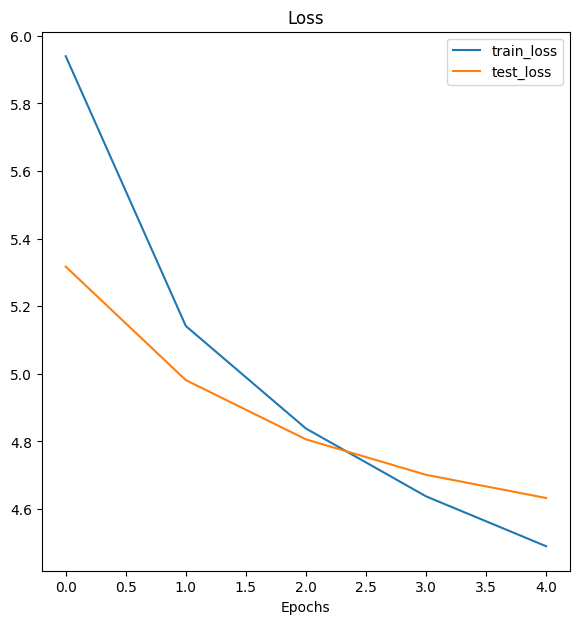

In [58]:
loss = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

results = train(model=model,
          train_data_loader = train_gen,
          test_data_loader = val_gen,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 5,
          device = device)

plot_loss_curves(results)

In [59]:
torch.save(model, 'gpt_model.pt')

In [60]:
model = torch.load('gpt_model.pt', map_location=torch.device(device), weights_only=False)

In [61]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
torch.hstack((a,b))

tensor([1, 2, 3, 4, 5, 6])

In [62]:
a = torch.tensor([[1],[2],[3]])
b = torch.tensor([[4],[5],[6]])
torch.hstack((a,b))

tensor([[1, 4],
        [2, 5],
        [3, 6]])

In [63]:
def generate(model, prompt='', max_len=32):
    tokenized_prompt = tokenizer(prompt, return_tensors='pt')
    input_ids = tokenized_prompt['input_ids'][:, :-1].to(device)
    # inpuut_ids.shape: [1, seq]
    while(len(input_ids[0]) < max_len):
        outputs = model(input_ids)
        # outputs 1 x T x vocab_size
        prediction_id = torch.argmax(outputs[:, -1, :], axis=-1)

        if prediction_id.squeeze(0).item() == tokenizer.eos_token_id:
            break

        input_ids = torch.hstack((input_ids, prediction_id.view(1, 1)))

    return tokenizer.decode(input_ids[0][1:])

In [64]:
generate(model, "Blade Runner")

'Blade Runner is a great actor, but he is a great actor. The story is a great movie, but it is a great movie. The'

In [65]:
generate(model, "Dune is ")

"Dune is 1980's. The film is a great film, but it is a great film. The story is a great film,"

In [66]:
generate(model, "The worst ")

'The worst 2000000000000000000000000000'

In [67]:
generate(model, "Facinating ")

'Facinating 1980s, and I have seen this movie, and I have seen it again. I have seen it many times, and'

In [68]:
def generate_with_temp(model, prompt='', max_len=32, temperature=0.4):
    tokenized_prompt = tokenizer(prompt, return_tensors='pt')
    input_ids = tokenized_prompt['input_ids'][:, :-1].to(device)

    while(len(input_ids[0]) < max_len):
        outputs = model(input_ids)
        # outputs.shape 1 x T x Vocab_size
        y = outputs[:, -1, :][0]
        # y.shape: Vocab_size
        distribution = torch.nn.functional.softmax(y / temperature, dim=0)
        prediction_id = np.random.choice(tokenizer.vocab_size, p=distribution.cpu().detach().numpy())

        if prediction_id == tokenizer.eos_token_id:
            break

        input_ids = torch.hstack((input_ids, torch.tensor(prediction_id).to(device).view(1, 1)))

    return tokenizer.decode(input_ids[0][1:])

In [69]:
generate_with_temp(model, "Facinating ")

'Facinating 20000000006, 1000000000. I have always been'

In [70]:
generate_with_temp(model, "Dune is ", temperature=0.1)

"Dune is 1980's. The film is a must see for anyone who has seen it. The film is a great film. The"

In [71]:
generate_with_temp(model, "Dune is ", temperature=1)

'Dune is 17 from me in New Jersey, Fishburne is in fact very good during his Oscar-nominated role, this incidentally awful'

In [72]:
generate_with_temp(model, "Dune is ", temperature=2)

'Dune is filuring buyer based firing questions Bad scenery, while Similarly cigarettes focus on Normandy Theatre StewartindAIDS Hercop Romole ne <briety'

In [73]:
generate_with_temp(model, "The worst ")

"The worst 20000003 movie ever made. I'm not sure if the movie was good, but it's not bad."

In [74]:
generate_with_temp(model, "Facinating ")

'Facinating 1996, 19998, 1971, 198, 197.'